In [1]:
#http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58ca8000 @  0x7efcf801c2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import FloatTensor
import sklearn.datasets
import matplotlib.pylab as plt
import random
import math
from IPython import display
import seaborn as sbn
import pandas as pd
%matplotlib inline

In [3]:
root = './data'

train_set = dataset.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
test_set = dataset.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=100,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

device = torch.device("cuda")

Processing...
Done!


# Классический Autoencoder

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], 1, 28, 28)

In [0]:
class lin_ae(nn.Module):
  
    def __init__(self):
        super(lin_ae, self).__init__()
        
        self.encoder = nn.Sequential( 
            Flatten(),
            nn.Linear(784, 500),
            nn.ReLU(),
            nn.Linear(500, 250), 
            nn.ReLU(),
            nn.Linear(250, 100), 
            nn.ReLU(),
            nn.Linear(100, 10), 
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 784),
            UnFlatten()
            
        )
        
        self.initialize()
        
    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform(m.weight)
        
    def forward(self, x):
        x = self.encoder(x)
        self.embeding = x
        x = self.decoder(x)
        return x

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


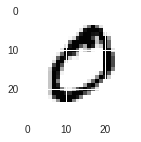

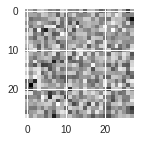

In [7]:
# Инициализируем сеть и убеждаемся, что изначально она выдает мусор.
net = lin_ae().cuda()
x = train_set[1][0].cuda()
y = net(x)

plt.figure(figsize=(2,2))
plt.imshow(train_set[1][0].numpy()[0])

plt.figure(figsize=(2,2))
plt.imshow(y.cpu().data.numpy()[0,0])

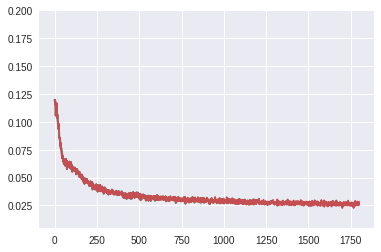

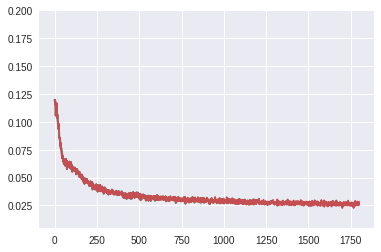

In [8]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_aсс = []

for ep in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        y = net(data.cuda())
        loss = criterion(y, data.cuda())
        loss.backward()
        optimizer.step()

        loss_aсс.append(loss.data[0])
        
    plt.ylim(0.005, 0.2)
    plt.grid(True)
    plt.plot(loss_aсс)
    display.clear_output(wait=True)
    display.display(plt.gcf())

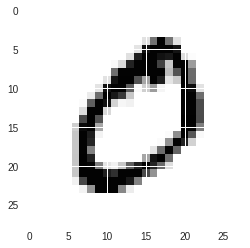

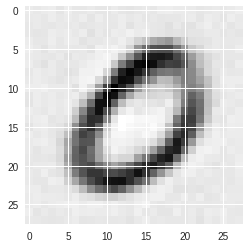

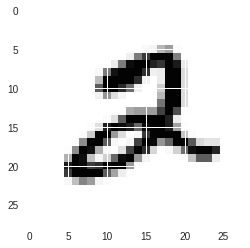

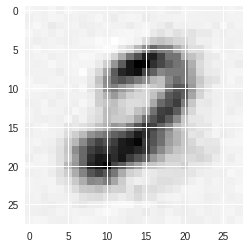

In [9]:
x = train_set[1][0].cuda()
y = net(x)
plt.imshow(x[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()


x = train_set[5][0].cuda()
y = net(x)
plt.imshow(x[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()


# Denoising

In [0]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.5
    noisy_img = img + noise.cuda()
    return noisy_img

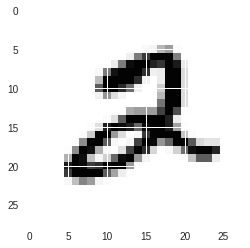

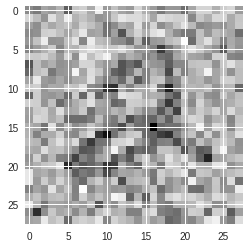

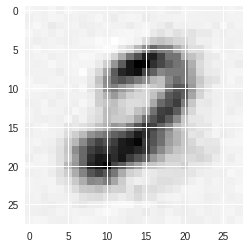

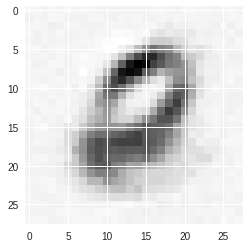

In [11]:
x = train_set[5][0].cuda()
y = net(x)
x_n = add_noise(x)
y_n = net(x_n)

plt.imshow(x[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(x_n[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()
plt.imshow(y_n.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()



In [12]:
dae_net = lin_ae().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


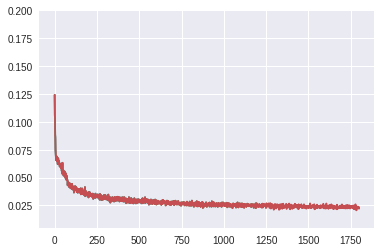

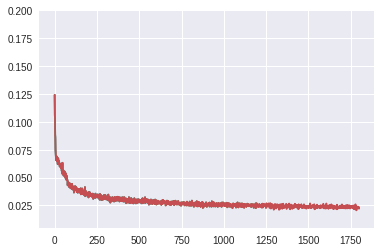

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(dae_net.parameters(), lr=0.001)

loss_aсс = []

for ep in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        y = dae_net(add_noise(data.cuda()))
        loss = criterion(y, data.cuda())
        loss.backward()
        optimizer.step()

        loss_aсс.append(loss.data[0])
        
    plt.ylim(0.005, 0.2)
    plt.grid(True)
    plt.plot(loss_aсс)
    display.clear_output(wait=True)
    display.display(plt.gcf())

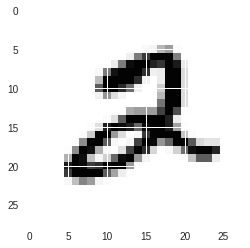

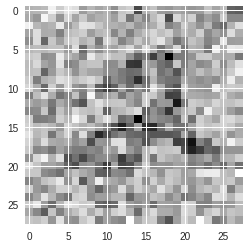

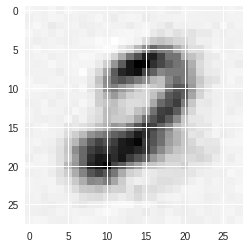

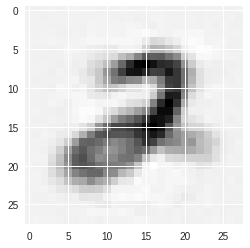

In [14]:
x = train_set[5][0].cuda()
y = net(x)
x_n = add_noise(x)
y_n = dae_net(x_n)

plt.imshow(x[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(x_n[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()
plt.imshow(y_n.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()



# Variational Autoencoder (VAE)

In [0]:
class conv_vae(nn.Module):
    
    def __init__(self):
        super(conv_vae, self).__init__()
        
        self.encoder = nn.Sequential( # 1x28x28 ->
            nn.Conv2d(1, 8, 3), # 8x26x26
            nn.ReLU(),
            
            nn.Conv2d(8, 16, 3), # 16x24x24
            nn.ReLU(),
            nn.MaxPool2d(2), # 16x12x12
            
            nn.Conv2d(16, 32, 3), # 32x10x10
            nn.ReLU(),
            nn.MaxPool2d(2), #32x5x5
            
            nn.Conv2d(32, 64, 3), # 32x3x3 = 288
            nn.ReLU(),
            nn.MaxPool2d(3), # 64x1x1
            
        )
        
        self.mu = nn.Linear(64, 2)
        self.logvar = nn.Linear(64, 2)
        
        
        self.decoder = nn.Sequential(
            nn.Conv2d(2, 64, 1, 1),
            nn.Upsample(scale_factor=3),

            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(16, 8, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(8, 1, 3),
            nn.ReLU()
            
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 64)
        return self.mu(x), self.logvar(x)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        self.z = z.view(-1, 2, 1, 1)
        x = self.decoder(self.z)
        return x, mu, logvar

In [0]:
class linear_vae(nn.Module):
    
    def __init__(self):
        super(linear_vae, self).__init__()
        
        self.encoder = nn.Sequential( 
            Flatten(),
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500), 
            nn.ReLU(),
            nn.Linear(500, 100), 
            nn.ReLU(),
            nn.Linear(100, 64), 
        )
        
        self.mu = nn.Linear(64, 2)
        self.logvar = nn.Linear(64, 2)
        
        self.decoder = nn.Sequential(
            Flatten(),
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 784),
            UnFlatten()
            
        )
        self.initialize()
        
    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform(m.weight)
            
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 64)
        return self.mu(x), self.logvar(x)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        self.z = z.view(-1, 2, 1, 1)
        x = self.decoder(self.z)
        return x, mu, logvar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


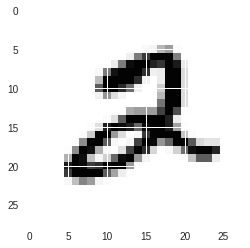

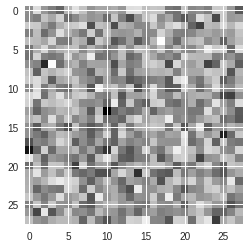

In [17]:
vae_net = linear_vae().cuda()
x = train_set[5][0].cuda()
y,_,_ = vae_net(x)

plt.imshow(x[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()

In [0]:
mse_loss = nn.MSELoss().cuda()
def loss_function(recon_x, x, mu, logvar, batch_size):
    BCE = mse_loss(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_size * 784.

    return BCE + KLD


In [0]:
optimizer = torch.optim.Adam(vae_net.parameters(), lr=0.001)

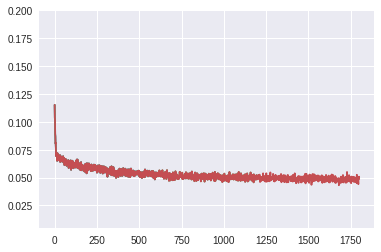

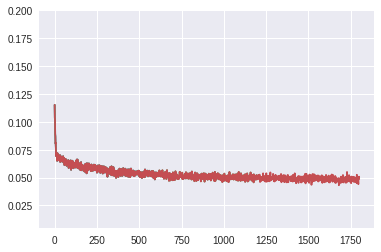

In [20]:
loss_aсс = []

for ep in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        y, mu, logvar = vae_net(data.cuda())
        loss = loss_function( y, data.cuda(), mu, logvar, data.size()[0] )
        loss.backward()
        optimizer.step()
        loss_aсс.append(loss.data[0])
        
    plt.ylim(0.005, 0.2)
    plt.grid(True)
    plt.plot(loss_aсс)
    display.clear_output(wait=True)
    display.display(plt.gcf())

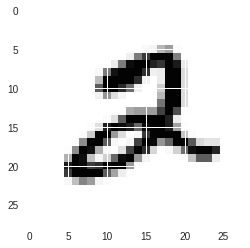

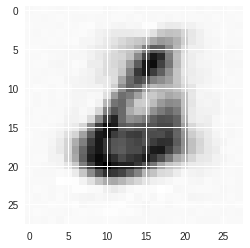

In [21]:
x = train_set[5][0].cuda()
y,_,_ = vae_net(x)

plt.imshow(x[0].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
plt.show()
plt.imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")
plt.show()